100%|██████████| 100/100 [00:02<00:00, 47.54it/s]


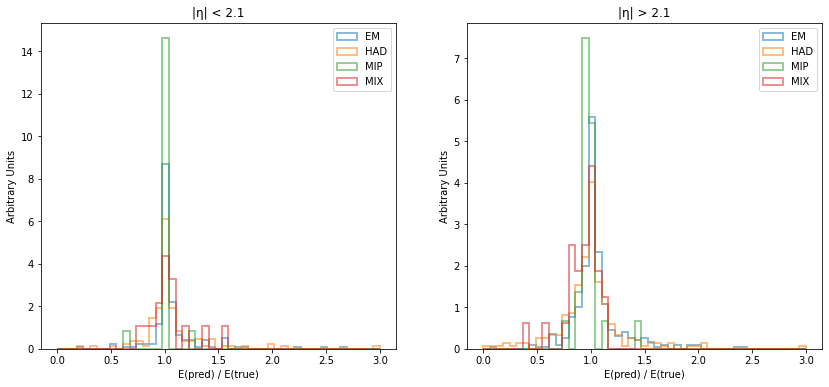

In [5]:
import pickle
import numpy as np
import torch
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set file pattern and file limit
file_pattern = r'C:\Users\tsoli\OneDrive\Documents\School\1 - University of Minnesota\Year 17\Year 1 Research\picklefiles\tau\*.pkl'
file_limit = 100

# Load data from pkl files
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
        score_noise_filter = pickle.load(f)
        pass_noise_filter = pickle.load(f)
        out_gravnet = pickle.load(f)
    return data, score_noise_filter, pass_noise_filter, out_gravnet

# Clustering algorithm from plots3D.
def get_clustering(beta, X, threshold_beta=0.2, threshold_dist=0.5):
    n_points = beta.shape[0]
    select_condpoints = beta > threshold_beta
    indices_condpoints = np.nonzero(select_condpoints)[0]
    indices_condpoints = indices_condpoints[np.argsort(-beta[select_condpoints])]
    unassigned = np.arange(n_points)
    clustering = -1 * np.ones(n_points, dtype=np.int32)
    
    for index_condpoint in indices_condpoints:
        d = np.linalg.norm(X[unassigned] - X[index_condpoint], axis=-1)
        assigned_to_this_condpoint = unassigned[d < threshold_dist]
        clustering[assigned_to_this_condpoint] = index_condpoint
        unassigned = unassigned[~(d < threshold_dist)]
    
    return clustering

# Collecting raw data.
def process_data(data):
    true_energies = data.x[:, 0].numpy()
    true_clusters = data.y.numpy()
    eta_values = data.x[:, 1].numpy()
    true_pdgids = data.truth_cluster_props[:, 4].numpy()
    return true_energies, true_clusters, eta_values, true_pdgids

# Parsing raw data.
def process_gravnet(score_noise_filter, pass_noise_filter, out_gravnet):
    beta = torch.sigmoid(out_gravnet[:, 0]).numpy()
    cluster_space_coords = out_gravnet[:, 1:].numpy()
    pred_clusters_pnf = get_clustering(beta, cluster_space_coords, threshold_beta=0.2, threshold_dist=0.5)
    pred_clusters = np.zeros_like(pass_noise_filter, dtype=np.int32)
    pred_clusters[pass_noise_filter] = pred_clusters_pnf
    return pred_clusters

# Match algorithm from matching.py
def match(clustering1, clustering2, weights=None, threshold=0.2, noise_index=0):
    if weights is None:
        weights = np.ones_like(clustering1)
    cluster_ids1, cluster_indices1 = np.unique(clustering1, return_inverse=True)
    cluster_ids2, cluster_indices2 = np.unique(clustering2, return_inverse=True)
    n_clusters1 = cluster_ids1.shape[0]
    n_clusters2 = cluster_ids2.shape[0]
    
    # Pre-calculate all 'areas' for all clusters
    areas1 = {id: weights[clustering1 == id].sum() for id in cluster_ids1}
    areas2 = {id: weights[clustering2 == id].sum() for id in cluster_ids2}
    
    # Make list of all pairs
    a = np.repeat(np.arange(n_clusters1), n_clusters2)
    b = np.repeat(np.expand_dims(np.arange(n_clusters2), -1), n_clusters1, axis=1).T.ravel()
    pairs = np.vstack((cluster_ids1[a], cluster_ids2[b])).T
    
    if noise_index is not None:
        # Remove pairs with a noise index in there
        pairs = pairs[~np.amax(pairs == noise_index, axis=-1).astype(bool)]
    
    # Calculate weighted ioms
    ioms = np.zeros(pairs.shape[0])
    intersections = np.zeros(pairs.shape[0])
    for i_pair, (id1, id2) in enumerate(pairs):
        intersection = weights[(clustering1 == id1) & (clustering2 == id2)].sum()
        minimum = min(areas1[id1], areas2[id2])
        ioms[i_pair] = intersection / minimum
        intersections[i_pair] = intersection
    
    # Sort
    order = np.argsort(intersections)[::-1]
    intersections = intersections[order]
    ioms = ioms[order]
    pairs = pairs[order]
    
    # Matching algo
    canhavemorematches_1 = set(cluster_ids1)
    canhavemorematches_2 = set(cluster_ids2)
    matched_1 = set()
    matched_2 = set()
    matches = []
    
    for iom, intersection, (i1, i2) in zip(ioms, intersections, pairs):
        if iom < threshold:
            continue
        if i1 not in canhavemorematches_1 or i2 not in canhavemorematches_2:
            continue
        if i1 in matched_1 and i2 in matched_2:
            continue
        # Make the match
        matches.append([i1, i2, iom])
        if i1 in matched_1:
            i2s = [j2 for j1, j2, _ in matches if j1 == i1]
            canhavemorematches_2.difference_update(i2s)
        elif i2 in matched_2:
            i1s = [j1 for j1, j2, _ in matches if j2 == i2]
            canhavemorematches_1.difference_update(i1s)
        matched_1.add(i1)
        matched_2.add(i2)
    
    if len(matches) == 0:
        print('Warning: No matches at all')
        return [], [], []
    
    matches = np.array(matches)
    i1s, i2s, ioms = matches[:, 0].astype(np.int32), matches[:, 1].astype(np.int32), matches[:, 2]
    return i1s, i2s, ioms

# Group matching
def group_matching(i1s, i2s, return_lists=True):
    match_dict_1_to_2 = {}
    match_dict_2_to_1 = {}
    is_used_1 = set()
    is_used_2 = set()
    for i1, i2 in zip(i1s, i2s):
        i1 = int(i1)
        i2 = int(i2)
        i1_used = i1 in is_used_1
        i2_used = i2 in is_used_2
        if not(i1_used) and not(i2_used):
            match_dict_1_to_2[i1] = [i2]
            match_dict_2_to_1[i2] = [i1]
            is_used_1.add(i1)
            is_used_2.add(i2)
        elif i1_used and i2_used:
            raise Exception(
                f'Detected many-to-many match:'
                f' [left]{i1} and [right]{i2} are both already matched to something else'
            )
        elif i1 in is_used_1:
            match_dict_1_to_2[i1].append(i2)
            match_dict_2_to_1.pop(i2, None)
        elif i2 in is_used_2:
            match_dict_2_to_1[i2].append(i1)
            match_dict_1_to_2.pop(i1, None)
    if return_lists:
        matches = [[[k], v] for k, v in match_dict_1_to_2.items()]
        matches.extend([[v, [k]] for k, v in match_dict_2_to_1.items() if len(v) > 1])
    else:    
        matches = [[k, (v if len(v) > 1 else v[0])] for k, v in match_dict_1_to_2.items()]
        matches.extend([[v, k] for k, v in match_dict_2_to_1.items() if len(v) > 1])
    return matches

# Make matches
def make_matches(event, prediction, tbeta=0.2, td=0.5, clustering=None):
    if clustering is None:
        clustering = cluster(prediction, tbeta, td)
    i1s, i2s, _ = match(event.y, clustering, weights=event.energy)
    matches = group_matching(i1s, i2s)
    return matches

def get_category(truth_ids):
    em_ids = np.array([11, 22, 111])
    mip_ids = np.array([13])
    if np.all(np.isin(truth_ids, em_ids)):
        return 0  # EM
    elif np.all(np.isin(truth_ids, mip_ids)):
        return 2  # MIP
    elif np.any(np.isin(truth_ids, em_ids)) or np.any(np.isin(truth_ids, mip_ids)):
        return 3  # MIX
    else:
        return 1  # HAD


# Histogram generator.
def accumulate_histograms(hist_data, data, score_noise_filter, pass_noise_filter, out_gravnet):
    true_energies, true_clusters, eta_values, true_pdgids = process_data(data)
    pred_clusters = process_gravnet(score_noise_filter, pass_noise_filter, out_gravnet)
    
    i1s, i2s, _ = match(true_clusters, pred_clusters, weights=true_energies)
    matches = group_matching(i1s, i2s)
    
    for truth_ids, pred_ids in matches:
        if 0 in truth_ids or -1 in pred_ids:
            continue
        
        mask_truth = np.isin(true_clusters, truth_ids)
        mask_pred = np.isin(pred_clusters, pred_ids)
        
        true_energy_sum = true_energies[mask_truth].sum()
        pred_energy_sum = true_energies[mask_pred].sum()
        
        ratio = pred_energy_sum / true_energy_sum
        eta_region = np.abs(eta_values[mask_truth].mean()) < 2.1
        
        category = get_category(np.unique(true_pdgids[mask_truth]))
        labels = ['EM', 'HAD', 'MIP', 'MIX']
        
        if eta_region:
            hist_data['low_eta'][labels[category]].append(ratio)
        else:
            hist_data['high_eta'][labels[category]].append(ratio)

def main():
    files = glob.glob(file_pattern)[:file_limit]

    hist_data = {
        'low_eta': {'EM': [], 'HAD': [], 'MIP': [], 'MIX': []},
        'high_eta': {'EM': [], 'HAD': [], 'MIP': [], 'MIX': []}
    }

    for file_path in tqdm(files):
        data, score_noise_filter, pass_noise_filter, out_gravnet = load_data(file_path)
        accumulate_histograms(hist_data, data, score_noise_filter, pass_noise_filter, out_gravnet)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    for label in ['EM', 'HAD', 'MIP', 'MIX']:
        low_eta_data = hist_data['low_eta'][label]
        high_eta_data = hist_data['high_eta'][label]
        
        ax1.hist(low_eta_data, bins=np.linspace(0, 3, 50), alpha=0.5, label=label, histtype='step', density=True, linewidth=2)
        ax2.hist(high_eta_data, bins=np.linspace(0, 3, 50), alpha=0.5, label=label, histtype='step', density=True, linewidth=2)
    
    ax1.set_title('|η| < 2.1')
    ax2.set_title('|η| > 2.1')
    for ax in (ax1, ax2):
        ax.set_xlabel('E(pred) / E(true)')
        ax.set_ylabel('Arbitrary Units')
        ax.legend()
    
    plt.show()

if __name__ == '__main__':
    main()
